# Maven Power Outage Challenge - Exploratory Data Analysis

For this milestone I will be cleaning and analysing the Maven Analytics "Power Outage Challenge" dataset. 

Electricity outages are a growing concern as we enter an age of unprecedented energy demand and climate disasters. This dataset contains power outage data from across the USA going back to 2002. There are quite a few issues with data quality. 

## Step 0. Understanding the data

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium 
import openpyxl

In [87]:
# Define the sheet names in a list so that we can easily iterate through the excel sheets (tabs). 
# Each sheet contains power outage event data for a single year between 2002 and 2023

sheet_names = [str(n) for n in range(2002, 2024, 1)]

In [88]:
# Creating a dictionary of pandas dataframes, one dataframe per excel sheet. 
# this will allow us to tailor our data cleaning to the individual sheet since the format of the sheet changes over the years.

DF_dict = {}

for sheet in sheet_names:
    if sheet in ["2002", "2008"]:
        header_value = 2
    else:
        header_value = 1
    
    DF_dict["{0}".format(sheet)] = pd.read_excel('DOE_Electric_Disturbance_Events.xlsx', 
                                                 engine='openpyxl', 
                                                 header=header_value, 
                                                 sheet_name=sheet)

In [89]:
# We will not use this right now, but the dictionary starting_shapes will help us to 
# understand the data better as we are cleaning

starting_shapes = {}
for sheet in sheet_names:
    starting_shapes[sheet + "_startshape"] = DF_dict[str(sheet)].shape
    
starting_shapes

{'2002_startshape': (39, 8),
 '2003_startshape': (117, 8),
 '2004_startshape': (134, 8),
 '2005_startshape': (128, 8),
 '2006_startshape': (112, 8),
 '2007_startshape': (97, 8),
 '2008_startshape': (190, 12),
 '2009_startshape': (124, 8),
 '2010_startshape': (144, 8),
 '2011_startshape': (321, 19),
 '2012_startshape': (222, 12),
 '2013_startshape': (188, 9),
 '2014_startshape': (232, 12),
 '2015_startshape': (191, 12),
 '2016_startshape': (191, 12),
 '2017_startshape': (191, 12),
 '2018_startshape': (220, 11),
 '2019_startshape': (278, 11),
 '2020_startshape': (383, 11),
 '2021_startshape': (387, 11),
 '2022_startshape': (390, 11),
 '2023_startshape': (167, 12)}

In [90]:
# Now lets check out one of the dataframes to see if we get the data we expect:
DF_dict["2008"].head()

,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Date/Time,NaN,NaN,NaN,NaN
1,January,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2008-01-04 00:00:00,WECC,4:00 a.m.,Northern California,Winter Storm,500,2606931,5:00 p.m. January 14,NaN,NaN,NaN,NaN
3,2008-01-04 00:00:00,WECC,7:47 a.m.,Sacramento County,Severe Storm,300,150000,4:30 p.m. January 04,NaN,NaN,NaN,NaN
4,2008-01-29 00:00:00,WECC,5:00 a.m.,"San Francisco Bay Area, California",Exciter Faulted,NaN,-,12:17 p.m. January 29,NaN,NaN,NaN,NaN


The data above is what I expect, however it is very messy! Generally I will need to:
- Make sure columns in each dataframe match (i.e. contain the same feature information)
- Check data within the columns to ensure quality
- Concatenate the source dataframes to create a single dataframe
- Pre-process the data to address inconsistencies before EDA

In [91]:
# Now lets explore how the column names vary between dataframes. Each row shows the column titles:

column_title_dictionary = {"{0}".format(sheet):DF_dict["{0}".format(sheet)].columns.tolist() for sheet in sheet_names}
column_title_df = pd.DataFrame.from_dict(column_title_dictionary, orient='index') #use the orient argument to make the keys of the dictionary equivalent to the index values of the dataframe
column_title_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2002,Date,NERC Region,Time,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time,None,None,None,None,None,None,None,None,None,None,None
2003,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2004,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2005,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2006,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2007,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1[1],Restoration,None,None,None,None,None,None,None,None,None,None,None
2008,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,None,None,None,None,None,None,None
2009,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2010,Date,NERC Region,Time,Area Affected,Type of Disturbance,Loss (megawatts),Number of Customers Affected 1,Restoration,None,None,None,None,None,None,None,None,None,None,None
2011,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18


### The target column names

From the dataframe above, we can see that the columns titles make a significant change two times between 2002 - 2023. 

I will approach the data cleaning process slightly differently for each of the three periods: 2002-2010, 2011-2014, 2015-2023

Here are the column names that I will have in the cleaned and concatenated dataframe:
1. "datetime_event_began", 
2. "NERC_region", 
3. "area_affected", 
4. "event_type", 
5. "demand_loss_(MW)", 
6. "number_of_customers_affected", 
7. "datetime_of_restoration"

In [92]:
post_cleaning_column_titles = ["datetime_event_began", 
                               "NERC_region", 
                               "area_affected", 
                               "event_type", 
                               "demand_loss_(MW)", 
                               "number_of_customers_affected", 
                               "datetime_of_restoration"]

## Step 1. Cleaning the data

### Cleaning dataframes from the years 2002 - 2010:

In [93]:
# Lets create a function that takes a dataframe, iterates through the rows, and checkes that the "Date" column to a 
# datetime datatype. otherwise it drops the row because this indicates the row is an unexpected format and in this instance 
# most likely a human readable marker.

from datetime import datetime

def drop_non_datetime_values(dataframe_name, column_name):
    for ind, row in dataframe_name.iterrows():
        if type(dataframe_name[column_name][ind]) == datetime:
            pass
        else:
            print(dataframe_name[column_name][ind]) # I have decided to print out the dropped data to make sure I am not dropping anyting unexpected. 
            dataframe_name.drop(axis=0, index=ind, inplace=True)
    return dataframe_name
           

In [94]:
# Removing rows from the dataframe that are redundant or that repeat the column names.
for sheet in list(range(2002,2011,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date")

January
None
February
March
April
None
July
August
October
November
None
December
None
nan
Note: North American Electric Reliability Council region acronyms are defined in the glossary.
Source:  Form EIA-417, "Electric Emergency Incident and Disturbance Report"
nan
January
February
March
None
April
None
None
None
None
None
None
None
May
None
None
None
None
None
June
None
None
None
None
None
July
nan
nan
Table B.2.
(Continued)
Date
August
None
None
None
None
None
None
None
September
nan
nan
Table B.2.
(Continued)
Date
nan
October
November
December
1 = Estimated Values.
* Information as provided by the respondent.  The occurrence is, however, associated with the 
massive blackout of August 14, 2003.  For further information, refer to the Interim Report: 
Causes of the August 14 Blackout in the United States and Canada, November 2003 at  
http://www.energy.gov/engine/content.do.  
Note: North American Electric Reliability Council region acronyms are defined in the glossary.
Source:  Form 

In [95]:
# We have discovered some "Time" value that can not be changed to a time datatype due to how 
# they have been entered into the database. I will adjust these one-by-one to preserve as much information as possible:

DF_dict["2002"].loc[3, "Time"] = "20:00:00"  # Original value = "Evening"
DF_dict["2003"].loc[56, "Time"] = "15:00:00" # Original value = "Approximately 3:00 p.m."
DF_dict["2003"].loc[78, "Time"] = "12:00:00" # Original value = "12:00 noon"
DF_dict["2004"].loc[3, "Time"] = "00:00:00"  # Original value = "Midnight"
DF_dict["2004"].loc[81, "Time"] = "09:52:00" # Original value = "9: 52 a.m."
DF_dict["2005"].loc[13, "Time"] = "17:28:00" # Original value = "5:78 p.m."
DF_dict["2005"].loc[21, "Time"] = "00:00:00" # Original value = "Midnight"
DF_dict["2006"].loc[12, "Time"] = "00:00:00" # Original value = "Ongoing"

# This is the code I used to find the index value of the problematic time data:
# DataFrame_dict["sheet2006"][DataFrame_dict["sheet2006"]["Time"] == "Ongoing"].index.values[0]

In [96]:
# Now that the date and time columns are in a format that can be recognised by pd.to_datetime, 
# lets concatenate these two columns

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)]['Date'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]['Time'].astype(str))

In [97]:
# Now that the time data is included in the first column of our dataframe we can drop the "Time" column 
# from the dataframes containing data for years 2002 - 2010

for sheet in list(range(2002,2011,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop("Time", axis=1)

In [98]:
DF_dict["2002"].head()

,Date,NERC Region,Area,Type of Disturbance,Loss (megawatts),Number of Customers Affected,Restoration Time
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [99]:
# Now that dataframes for 2002 - 2010 are fairly clean let us standardise the column names so we can concatenate the dataframes:

for sheet in list(range(2002,2011,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns. some sheets had extra columns filled with NaNs
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)


In [100]:
DF_dict["2002"].head() #Note, there is still some cleaning to do but we have the dataframe in the general format we want

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
3,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
4,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
6,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
8,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00


In [108]:
## KEEP WORKING ON THIS CODE BLOCK- NOT FINISHED

# Before we move on to clean the next section of sheets lets 
# create a function that attempts to standardise the format of the column titled "datetime_of_restoration"

def standardise_date_format(date_val):
    try:
        date_val = datetime.strptime(str(date_val), "%Y-%m-%d %H:%M:%S")
    except:
        try:
            date_val = datetime.strptime(str(date_val), "%-m/%d/%y, %-I:%M %p)
        except:
            
        
        
        date_val = None
        
    return date_val
            
    

In [109]:
DF_dict["2002"]["datetime_of_restoration_cleaned"] = DF_dict["2002"]["datetime_of_restoration"].apply(standardise_date_format)

In [110]:
DF_dict["2002"]["datetime_of_restoration_cleaned"]

1    2002-02-07 12:00:00
3                    NaT
4    2002-02-10 21:00:00
6    2002-02-27 11:35:00
8    2002-03-11 12:00:00
10   2002-04-09 00:00:00
13   2002-07-09 19:54:00
14   2002-07-19 16:30:00
15   2002-07-20 20:12:00
17   2002-08-02 18:36:00
18   2002-08-09 12:13:00
19   2002-08-25 09:17:00
20   2002-08-28 15:38:00
22   2002-10-12 00:00:00
24                   NaT
25                   NaT
27   2002-11-21 08:00:00
29   2002-12-09 22:30:00
30   2002-12-13 22:00:00
32   2002-12-19 16:00:00
33   2002-12-21 17:00:00
34   2002-12-26 05:00:00
35   2002-12-27 08:30:00
Name: datetime_of_restoration_cleaned, dtype: datetime64[ns]

### Cleaning dataframes from the years 2011- 2015:

In [17]:
# Now we will move on to the dataframes that contain data for years 2011 - 2014. Lets look at the dataframe:
DF_dict["2012"].head()

,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Event Type,Demand Loss (MW),Number of Customers Affected,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,January,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2012-01-04 00:00:00,12:14:00,2012-01-04 00:00:00,12:14:00,"Tacoma, Washington",WECC,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
2,2012-01-05 00:00:00,10:35:00,2012-01-05 00:00:00,12:25:00,"CSWS/AEP West territory, Oklahoma",SPP,Sabotage,0,0,NaN,NaN,NaN
3,2012-01-05 00:00:00,10:28:00,2012-01-05 00:00:00,12:25:00,"Creek County, Oklahoma",SPP,Suspected physical attack,NaN,NaN,NaN,NaN,NaN
4,2012-01-09 00:00:00,14:30:00,2012-01-09 00:00:00,15:30:00,"Watertown, Connecticut",NPCC,Vandalism,NaN,NaN,NaN,NaN,NaN


In [18]:
# Step one, drop values from "Date Event Began" that are not datetime datatypes:
for sheet in list(range(2011,2015,1)):
    drop_non_datetime_values(DF_dict["{0}".format(sheet)], "Date Event Began")

In [19]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

def date_only(start_year, stop_year, name_of_date_col):
    for sheet in list(range(start_year, stop_year+1, 1)):
        DF_dict["{0}".format(sheet)][name_of_date_col] = pd.to_datetime(DF_dict["{0}".format(sheet)][name_of_date_col]).dt.date
        

In [20]:
#Let us make sure the first column contains the date only. 
# Initially some cells had date and time values which resulted in an error when I tried to merge columns later on.

date_only(2011,2014,'Date Event Began')

In [22]:
# Merge date and time information

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [23]:
#Let us make sure the third column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

for sheet in list(range(2011,2015,1)):
    for ind, row in DF_dict["{0}".format(sheet)].iterrows():
        if type(DF_dict["{0}".format(sheet)]['Date of Restoration'][ind]) != datetime:
            DF_dict["{0}".format(sheet)]['Date of Restoration'][ind] = datetime.now().date()
            #DataFrame_dict["sheet{0}".format(sheet)]['Time of Restoration'][ind] = datetime.now().time()
            
        if type(DF_dict["{0}".format(sheet)]['Time of Restoration'][ind]) == str:
            DF_dict["{0}".format(sheet)]['Time of Restoration'][ind] = "00:00:00"
    
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration']).dt.date
        

c:\python36-32\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python36-32\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [24]:
for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [25]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2011,2015,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [26]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [27]:
for sheet in list(range(2011,2015,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [28]:
DF_dict["2014"].head()

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
1,2014-01-06 19:50:00,RFC,District of Columbia,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
2,2014-01-06 19:50:00,RFC,Unknown,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:44:00
3,2014-01-06 19:52:00,RFC,Delaware,Voltage Reduction due to Severe Weather - Cold,Unknown,Unknown,2014-01-06 20:45:00
4,2014-01-06 20:45:00,RFC,Unknown,Public Appeal due to Severe Weather - Cold,Unknown,Unknown,2014-01-07 21:00:00
5,2014-01-06 19:50:00,RFC,Pennsylvania,Voltage Reduction due to Severe Weather - Cold,200,62000,2014-01-06 20:49:00


### Cleaning dataframes from the years 2016- 2023:

In [30]:
# Now we will move on to the dataframes that contain data for years 2015 - 2023. Lets look at the dataframe:
DF_dict["2018"].head()

,Month,Date Event Began,Time Event Began,Date of Restoration,Time of Restoration,Area Affected,NERC Region,Alert Criteria,Event Type,Demand Loss (MW),Number of Customers Affected
0,January,01/01/2018,18:21:00,01/02/2018,18:11:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
1,January,01/01/2018,17:43:00,Unknown,Unknown,Texas:,TRE,Public appeal to reduce the use of electricity...,Severe Weather,Unknown,Unknown
2,January,01/01/2018,21:37:00,01/02/2018,10:30:00,Tennessee:,SERC,Public appeal to reduce the use of electricity...,System Operations,Unknown,Unknown
3,January,01/02/2018,10:00:00,02/12/2018,08:00:00,New York: Niagara County;,NPCC,Fuel supply emergencies that could impact elec...,Fuel Supply Deficiency,675,Unknown
4,January,01/02/2018,07:30:00,Unknown,Unknown,South Carolina:,SERC,Public appeal to reduce the use of electricity...,Severe Weather,0,717000


In [31]:
# Drop month column because it is redundant and also drop alert criteria column, we will not be analysing this column this time. 

for sheet in list(range(2015,2024,1)):
    column_titles = DF_dict["{0}".format(sheet)].columns.tolist()
    if "Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Month"], axis=1)
    if "Event Month" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Month"], axis=1)
    if "Event Year" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Event Year"], axis=1)
    if "Alert Criteria" in column_titles:
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Alert Criteria"], axis=1)

In [32]:
#Let us make sure the first column contains the date only. initially some cells had date and time values which resulted in an error when I tried to merge columns later on

date_only(2015, 2023, "Date Event Began")

In [33]:
# We have data issues in sheets 2015, 2016, 2017. 
# The issue is that these sheets have many rows of NaNs at the very bottom of the spreadsheet that we need to remove

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 48
2016 50
2017 41
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [34]:
# instead of dropping rows that have NaN, how about we keep rows that are not NaN:

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date Event Began'].notna()]

In [35]:
# The code above has resolved the issues of the NaNs at the very bottom of some of the spreadsheets

for sheet in list(range(2015,2024,1)):
    datetime_col = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'], errors='coerce')
    print(sheet, datetime_col.isnull().sum())

2015 0
2016 0
2017 0
2018 0
2019 0
2020 0
2021 0
2022 0
2023 0


In [36]:
# keep rows that are not "Unknown" 
# (There are a significant number of unknown values that are preventing us from processing the datetime columns properly)

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][DF_dict["{0}".format(sheet)]['Date of Restoration'].str.strip(" ") !=  "Unknown"]

In [37]:
# Merge Date Event Began and Time Event Began 

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date Event Began'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date Event Began'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time Event Began"].astype(str))

In [38]:
# Now we want to combine the restoration date and restoration time columns. 
# But first we need to get rid of two problematic rows that are missing critical data

DF_dict["2022"].drop(66, axis=0, inplace=True)
DF_dict["2023"].drop(13, axis=0, inplace=True)

In [39]:
for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)]['Date of Restoration'] = pd.to_datetime(DF_dict["{0}".format(sheet)]['Date of Restoration'].astype(str) + ' ' + DF_dict["{0}".format(sheet)]["Time of Restoration"].astype(str))

In [40]:
# Now that the "Date Event Began" column and "Date of Restoration" columns include datetime we can drop the "Time Event Began" and "Time of Restoration" columns 
# from the dataframes containing data for years 2011 - 2014

for sheet in list(range(2015,2024,1)):
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(["Time Event Began", "Time of Restoration"], axis=1)

In [41]:
# Now we need to reorder the columns so they are in the same order as the initial sheets we cleaned.

for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)][[old_col[0], old_col[3], old_col[2], old_col[4], old_col[5], old_col[6], old_col[1]]]

In [42]:
for sheet in list(range(2015,2024,1)):
    old_col = DF_dict["{0}".format(sheet)].columns.tolist()
    for n in range(len(post_cleaning_column_titles)):
        DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].rename(columns={old_col[n]: post_cleaning_column_titles[n]})
        
    if len(old_col) > 7: #Drop all additional columns
        for x in range(7,len(old_col),1):
            DF_dict["{0}".format(sheet)] = DF_dict["{0}".format(sheet)].drop(old_col[x], axis=1)

In [43]:
DF_dict["2016"]

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2016-01-04 05:15:00,MRO,Wisconsin: Milwaukee County;,Sabotage,0,0,2016-01-05 08:00:00
1,2016-01-10 20:46:00,NPCC,Maine: Connecticut: Massachusetts: Vermont: Ne...,Weather,Unknown,59859,2016-01-11 05:25:00
2,2016-01-11 20:16:00,RFC,Pennsylvania: Chester County;,Vandalism,0,0,2016-01-11 23:00:00
3,2016-01-14 08:27:00,RFC,Delaware:,Vandalism,0,0,2016-01-14 12:00:00
4,2016-01-17 12:00:00,WECC,Utah: Salt Lake County;,Sabotage,0,0,2016-01-17 13:00:00
...,...,...,...,...,...,...,...
136,2016-12-16 07:45:00,WECC,Oregon: Multnomah County;,Vandalism,0,0,2016-12-16 08:45:00
137,2016-12-26 04:00:00,WECC,Washington:,Vandalism,0,0,2016-12-26 06:00:00
138,2016-12-28 04:03:00,WECC,California:,Fuel Supply Deficiency,0,0,2016-12-31 06:00:00
139,2016-12-30 08:55:00,NPCC,Vermont: Chittenden County;,Other,0,0,2016-12-30 08:56:00


### Creating a single dataframe

In [44]:
# Now that dataframes for 2002 - 2023 are fairly clean and standardised, lets concatenate them:

disturbances = DF_dict["2002"]

for sheet in list(range(2003,2024,1)):
    disturbances = disturbances.append(DF_dict["{0}".format(sheet)], ignore_index=True)

disturbances

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration
0,2002-01-30 06:00:00,SPP,Oklahoma,Ice Storm,500,1881134,2002-02-07 12:00:00
1,2002-01-29 20:00:00,SPP,Metropolitan Kansas City Area,Ice Storm,500-600,270000,NaN
2,2002-01-30 16:00:00,SPP,Missouri,Ice Storm,210,95000,2002-02-10 21:00:00
3,2002-02-27 10:48:00,WSCC,California,Interruption of Firm Load,300,255000,2002-02-27 11:35:00
4,2002-03-09 00:00:00,ECAR,Lower Peninsula of Michigan,Severe Weather,190,190000,2002-03-11 12:00:00
...,...,...,...,...,...,...,...
3613,2023-06-25 19:30:00,SERC,"Arkansas, Mississippi",- Weather or natural disaster,Unknown,64732,2023-06-26 17:45:00
3614,2023-06-27 17:37:00,WECC,"Washington, Idaho, Montana",- Failure at high voltage substation or switch...,0,0,2023-06-27 21:30:00
3615,2023-06-28 11:01:00,SERC,Georgia,- Vandalism - Theft,0,0,2023-06-28 11:03:00
3616,2023-06-22 02:30:00,SERC,Louisiana,- Transmission equipment failure,17,6242,2023-06-22 02:38:00


## More pre-processing - adjusting the datatypes for easier data manipulation

In [159]:
## Convert the columns "Datetime_event_began" and "Datetime_of_restoration" to a datetime datatype:

disturbances["datetime_event_began"] = pd.to_datetime(disturbances["datetime_event_began"], format= "%Y-%m-%d %H:%M:%S", utc=True)
#disturbances["datetime_of_restoration"] = pd.to_datetime(disturbances["datetime_of_restoration"], format= "%Y-%m-%d %H:%M:%S", utc=True)

In [46]:
# The column "number_of_customers_affected" is currently a string, lets try converting this to an int.

for ind, row in disturbances.iterrows():
    try:
        disturbances["number_of_customers_affected"][ind] = int(disturbances["number_of_customers_affected"][ind])
    except:
        disturbances["number_of_customers_affected"][ind] = None

c:\python36-32\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\python36-32\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [47]:
# Now lets convert the column "number of customers affected" to an int

disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].fillna(0).astype(int)
disturbances['number_of_customers_affected'] = disturbances['number_of_customers_affected'].astype(str).astype(int)

In [136]:
disturbances['demand_loss_(MW)'].iloc[742] = "0"  # Original value = "datetime(2011, 6, 8, 0, 0)"

# We will also convert the column "demand_loss_(MW)" to a float. But first we will replace some values that do not fit the fomat expected:
disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].replace({
    "500-600":"500",
    "200-250": "200",
    "75-90":"75",
    "75-90 ":"75",
    "230-300":"230",
    "500-1000":"500",
    "Approx. 18,500 MW, in MISO area:":"18500",
    "18,500":"18500",
    "4,100 MW (Northern NJ) and 400 MW, (Erie,  PA) area":"4500",
    "peak 1655 ":"1655",
    "500-700":"500",
    "Est. 371.1":"370",
    "Est. 75":"75",
    "Approx. 180":"180",
    "Est. 400":"400",
    "Less than 150":"150",
    "Approx. 300":"300",
    "Approx. 30  ":"30",
    "Less than 300":"300",
    "Approx. 100":"100",
    "Approx. 85":"85",
    "133 on 5/21/04  between 3:00 a.m. and 4:00  a.m., 392 on 5/21/04 between 4:00 p.m. and 5:00 p.m.":"525",
    "177 on 5/21/04 between 3:00 p.m. and 5:00 p.m.":"177",
    "60 at peak, ":"60",
    "-":"0",
    "Approx. 200":"200",
    'All':"0",
    "65 to 100":"65",
    "50-60 ":"50",
    "50-100":"50",
    'unknown':"0",
    '  N/A':"0",
    "--":"0",
    "0,":"0",
    "37- 40":"37",
    "100-140":"100",
    "80 to 100":"80",
    "300-500":"300",
    "65-80":"65",
    "8,000-10,000":"8000",
    "800-1,000":"800",
    "8-Jun":"0",
    "900-1000":"900",
    "UNK":"0",
    "Unknown":"0",
    "UNK ":"0",
})

disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].fillna(0).astype(int)
disturbances['demand_loss_(MW)'] = disturbances['demand_loss_(MW)'].astype(str).astype(float)

c:\python36-32\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [48]:
# There seem to be some NERC codes that have spaces, lets clean these up by removing the spaces:
disturbances["NERC_region"] = disturbances["NERC_region"].str.replace(" ", "")

# We also want to address some naming inconsistencies in the data:
disturbances["NERC_region"] = disturbances["NERC_region"].replace(
    {
        "RF":"RFC",
        "RF/SERC":"SERC/RF",
        "MRO/SERC":"SERC/MRO",
        "RFC;SERC":"SERC/RFC",
        "NPPC":"NPCC",
        "RF/MRO":"MRO/RF",
        "MR0":"MRO",
        "NPCC,RFC":"NPCC/RFC",
        "NPCC;RFC":"NPCC/RFC",
        "RFC,SERC":"SERC/RFC",
        "SPP,SERC,TRE":"SERC/SPP/TRE",
        "NP":"NPCC",
        "MECO":"Other",
        "REC":"Other",
        "HI":"Other",
        "MidwestISO(RFC":"Other",
        "TE":"Other",
        "WeEnergiesMAIN":"Other"
    })

In [163]:
disturbances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   datetime_event_began          3618 non-null   datetime64[ns]
 1   NERC_region                   3598 non-null   object        
 2   area_affected                 3618 non-null   object        
 3   event_type                    3618 non-null   object        
 4   demand_loss_(MW)              3618 non-null   float64       
 5   number_of_customers_affected  3618 non-null   int32         
 6   datetime_of_restoration       3617 non-null   object        
dtypes: datetime64[ns](1), float64(1), int32(1), object(4)
memory usage: 127.3+ KB


#### The features we want to work with ("datetime_event_began", "demand_loss_(MW)", and "number_of_customers_affected") are now in the correct format. EDA can begin!

In [166]:
# Remove the timezome for the column "datetime_event_began" so that we can write to excel:
#disturbances['datetime_event_began'] = disturbances['datetime_event_began'].dt.tz_localize(None)

In [168]:
# disturbances.to_csv('disturbances2002_2023_cleaned.csv')

ValueError: offset must be a timedelta strictly between -timedelta(hours=24) and timedelta(hours=24).

## Step 3. Exploratory Data Analysis (EDA)

This data exploration will focus on two features from the dataset: NERC Region and Demand Loss (MW). The North American Electric Reliability Corportion (NERC) is concerned about regional weknesses in the energy grid and want to know where to focus their energy if they want to improve energy reliability across their regional portfolio. This analysis is the first step toward understanding where the most powere outage events are happening as well as how much demand loss occers per event. 

### What North American Electric Reliability Corportion (NERC) regions had the most outages from 2002-2023?

In [173]:
# Create a dataframe that defines the NERC Region codes. We will use this as a legend for the figure below.

NERC_region_dict = {"NERC region codes":
    {"MRO": "Midwest Reliability Organisation",
    "NPCC": "Northeast Power Coordinating Council",
    "RFC": "ReliabilityFirst Corporation",
    "SERC": "SERC Reliability Corporation",
    "SPP": "Southwest Power Pool",
    "TRE": "Texas Reliability Entity",
    "WECC": "Western Electricity Coordinating Council",
    "FRCC": "Florida Reliability Coordinating Council",
    "MAPP": "Mid-continent Area Power Pool",
    "HECO": "Hawaiian Electric",
    "MAAC": "Mid-Atlantic Area Council",
    "WSCC": "Western Systems Coordinating Council",
    "MAIN": "Mid-America Interconnected Network",
    "ERCOT": "Electric Reliability Council of Texas",
    "ECAR": "East Central Area Reliability Coordination Agreement",
    "SPP RE": "SPP Regional Entity"}
}

NERC_region_df = pd.DataFrame(NERC_region_dict)

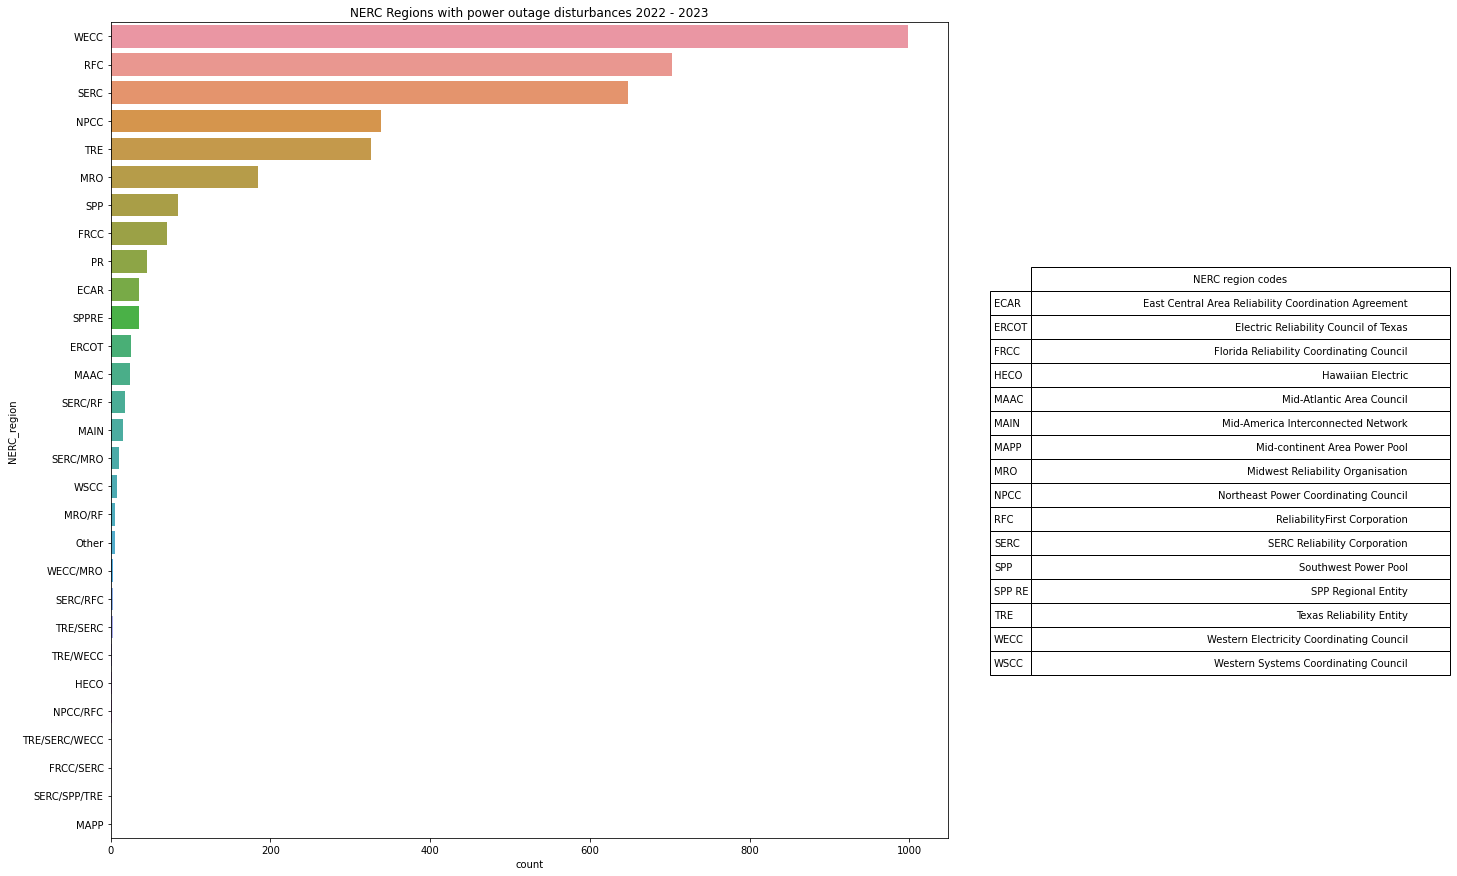

In [171]:
plt.figure(figsize=(15, 15))
sns.countplot(data=disturbances, y='NERC_region', order=disturbances['NERC_region'].value_counts().index, dodge=False)
plt.title("NERC Regions with power outage disturbances 2022 - 2023")

# Add a table to the right of the plot:
Legend_table = plt.table(cellText= NERC_region_df.values,
                        rowLabels= NERC_region_df.index,
                        colLabels= NERC_region_df.columns,
                        bbox=(1.1, .2, 0.5, 0.5))

plt.show()

From the figure above, we can see that the majority of outage events occur in 6-7 NERC regions. It is unclear at this stage whether this has anything to do with sampling bias. More analysis is necessary. My recommendation for NERC is to investigate the following regions more closely to see if there are grid weaknesses that need addressing. These regions had the most outage events from 2002 - 2023:
- Western Electricity Coordinating Council
- Reliability First Corporation
- SERC Reliability Corporation
- Northeast Power Coordinating Council
- Texas Reliability Entity
- Midwest Reliability Reliability Organisation

### How much demand loss (in MW) can be expected in a typical outage event? 

We will look at the regions of interested above and see what the demand loss looks like per region. 

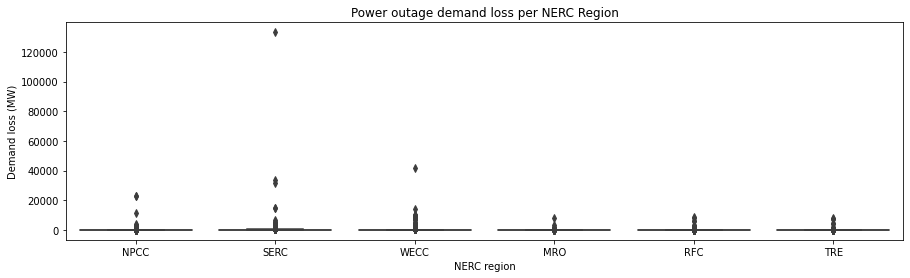

In [206]:
plt.figure(figsize=(15, 4))  #NOTE: Figsize needs to be executed before the boxplot method of else it will not apply
sns.boxplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='demand_loss_(MW)'
)

plt.title("Power outage demand loss per NERC Region")
plt.xlabel("NERC region")
plt.ylabel("Demand loss (MW)")
plt.show()

The data above if difficult to understand due to the outliers in the data. lets cap upper and lower bounds so that we can interpret our box plots better.

In [190]:
# Finding IQR:
q3 = disturbances["demand_loss_(MW)"].quantile(0.75)
q1 = disturbances["demand_loss_(MW)"].quantile(0.25)
iqr = q3 - q1 

# Get observations that are greater than 1.5 * iqr:
upper_bound = q3 + (1.5 * iqr)
lower_bound = q1 - (1.5 * iqr)

disturbances["demand_loss_(MW)_clipped"] = np.clip(disturbances["demand_loss_(MW)"], lower_bound, upper_bound)

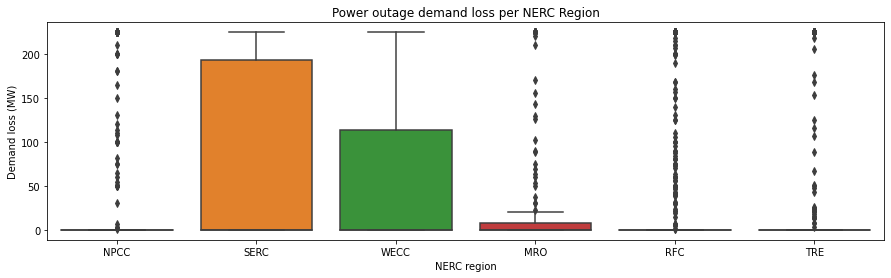

In [207]:
plt.figure(figsize=(15, 4))  #NOTE: Figsize needs to be executed before the boxplot method of else it will not apply
sns.boxplot(
    data=disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])],
    x='NERC_region',
    y='demand_loss_(MW)_clipped' #Use the clipped data to get rid of outliers
)

plt.title("Power outage demand loss per NERC Region")
plt.xlabel("NERC region")
plt.ylabel("Demand loss (MW)")
plt.show()

In [203]:
# Lets have a closer look at the 6 regions with the most logged disturbances. 

disturbances[disturbances['NERC_region'].isin(["WECC", "RFC", "SERC", "NPCC", "TRE", "MRO"])].groupby(["NERC_region"]).median()

,demand_loss_(MW),number_of_customers_affected,demand_loss_(MW)_clipped
NERC_region,,,
MRO,0.0,0,0.0
NPCC,0.0,0,0.0
RFC,0.0,57327,0.0
SERC,0.0,35239,0.0
TRE,0.0,0,0.0
WECC,0.0,0,0.0


Interesting, the median demand loss for these regions is zero. This does not seem right and means we need to have a closer look at the data. 
- Is demand loss being logged properly? 
- Do we have any negative values that could be skewing the data? 

More analysis needs to take place so that we can answer these questions

### Are there any major outliers in terms of demand loss? What are the features of these outliers?

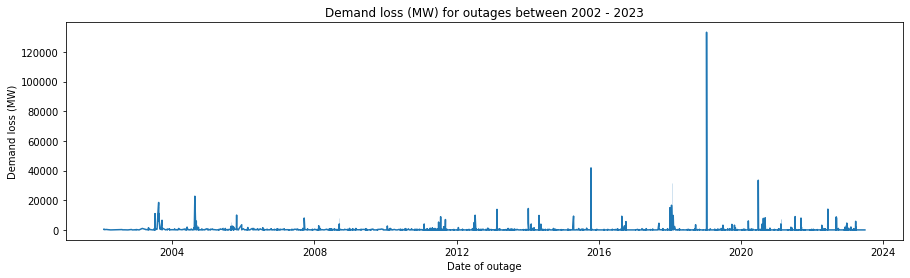

In [209]:
plt.figure(figsize=(15, 4))
sns.lineplot(data=disturbances, x='datetime_event_began', y="demand_loss_(MW)")

plt.title("Demand loss (MW) for outages between 2002 - 2023")
plt.xlabel("Date of outage")
plt.ylabel("Demand loss (MW)")
plt.show()

In [222]:
demand_loss_sorted = disturbances['demand_loss_(MW)'].sort_values(ascending=False)
demand_loss_sorted

2246    133200.0
1787     41788.0
2616     33480.0
2064     31500.0
52       22934.0
          ...   
2039         0.0
2038         0.0
2037         0.0
2035         0.0
3617         0.0
Name: demand_loss_(MW), Length: 3618, dtype: float64

In [226]:
# By sorting the data by demand loss we could get a rough idea about how we want to slice the data to view the events 
# that are responsible for the most demand loss.

disturbances[disturbances["demand_loss_(MW)"] > 10000]

,datetime_event_began,NERC_region,area_affected,event_type,demand_loss_(MW),number_of_customers_affected,datetime_of_restoration,demand_loss_(MW)_clipped
42,2003-07-08 04:00:00,ECAR,Ohio,Severe Thunderstorms,11000.0,134500,"7/11/03, 4:00 p.m.",224.375
47,2003-08-14 15:00:00,ECAR,Geographic areas for MISO Reliability Coordina...,Unknown *,18500.0,0,Approximately,224.375
48,2003-08-14 16:09:00,ECAR,Southeastern Michigan including all of Detroit,Unknown *,11000.0,2100000,"8/16/03, 7:00 a.m.",224.375
52,2003-08-14 16:10:00,NPCC,New York State,Unknown *,22934.0,0,"8/18/03, 12:03 a.m.",224.375
55,2003-08-14 16:11:00,NPCC,Entire Con Edison System (five boroughs of NYC...,Unknown *,11202.0,3125350,"8/15/03, 9:03 p.m.",224.375
142,2004-08-20 15:31:00,NPCC,"Boston, Massachusetts",Major Transmission Line Tripped due to Lightni...,22700.0,380000,"8/20/04, 9:45 p.m.",224.375
1323,2013-02-19 16:01:00,WECC,"Stockton, California",Electrical System Separation (Islanding),13850.0,6810,2013-02-20 12:55:00,224.375
1486,2014-01-07 07:58:00,SERC,North Carolina,Voltage Reduction; Public Appeal due to Severe...,14435.0,0,2014-01-07 11:00:00,224.375
1787,2015-10-13 16:32:00,WECC,California,Other,41788.0,0,2015-10-13 20:39:00,224.375
2055,2018-01-02 06:45:00,SERC,North Carolina: South Carolina:,Severe Weather,14998.0,0,2018-01-02 09:00:00,224.375


Severe weather seems to be the leading cause of the most disruptive power outages. over 50% of the top 14 outage events (ranked by demand loss) are caused by severe weather. More analysis will need to take place to understand what types of sever weather are most impactful to the energy grid. 

## Step 4 Conclusion and next steps

I spent a lot of time cleaning this data and the EDA I was able to complete by November 27th is a bit limited. I had a lot of fun working with this messy dataset but also have a lot of questions. I know there is a lot to improve. 

Some general notes:
- I wanted to explote the datetime columns more but the data was so messy and I was very stuck on timezones... I abandoned this so that I could at least submit something on time!


Other notes:
- NOTE: I have lost some of the merged cell data from the area column of 2002 sheet, to revisit and look at data dictionary for better understanding
- NOTE: Have i deleted some important data when cleaning my rows that are not datetime data? to review.
- NOTE: when converting the datetime columns to datetime datatypes I set utc=True. This will need to be reviewed.
- NOTE: This is where I found the NERC region code translations: https://www.eia.gov/outlooks/aeo/pdf/nerc_map.pdf